In [1]:

import numpy as np
import matplotlib.pyplot as plt
import mne
import pandas as pd
from braindecode.datasets import TUHAbnormal, BaseConcatDataset
from braindecode.preprocessing import (
    preprocess, Preprocessor, create_fixed_length_windows, create_windows_from_events, scale as multiply)
import torch
from braindecode.util import set_random_seeds

from braindecode.models import ShallowFBCSPNet, deep4
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import Trainer
from braindecode import EEGClassifier

from EEGClip.clip_models import EEGClipModule

mne.set_log_level('ERROR')  # avoid messages everytime a window is extracted

TUHAbnormal_PATH = '/home/jovyan/mne_data/TUH/tuh_eeg_abnormal/v2.0.0'
N_JOBS = 8  # specify the number of jobs for loading and windowing
N_SAMPLES = 1

tuh = TUHAbnormal(
    path=TUHAbnormal_PATH,
    recording_ids=list(range(N_SAMPLES)),
    target_name=('report','pathological'),
    preload=False,
    add_physician_reports=True,
    n_jobs=N_JOBS, 
)

print("length of dataset : ", len(tuh))

x, y = tuh[-1]
print('x:', x)
print('y:', y)

/home/jovyan/test_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Extracting EDF parameters from /home/jovyan/mne_data/TUH/tuh_eeg_abnormal/v2.0.0/edf/eval/normal/01_tcp_ar/041/00004196/s003_2009_09_03/00004196_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
length of dataset :  350500
x: [[3.5e-09]
 [3.5e-09]
 [3.5e-09]
 [3.5e-09]
 [3.5e-09]
 [3.5e-09]
 [3.5e-09]
 [3.5e-09]
 [3.5e-09]
 [3.5e-09]
 [3.5e-09]
 [3.5e-09]
 [3.5e-09]
 [3.5e-09]
 [3.5e-09]
 [3.5e-09]
 [3.5e-09]
 [3.5e-09]
 [3.5e-09]
 [3.5e-09]
 [3.5e-09]
 [3.5e-09]
 [3.5e-09]
 [3.5e-09]
 [3.5e-09]
 [3.5e-09]
 [3.5e-09]
 [3.5e-09]
 [3.5e-09]
 [3.5e-09]
 [3.5e-09]
 [3.5e-09]
 [0.0e+00]
 [0.0e+00]
 [0.0e+00]
 [0.0e+00]]
y: ['CLINICAL HISTORY:  Seizures.\nMEDICATIONS: Dilantin,  Lipitor.\nINTRODUCTION:  Digital video EEG is performed in the lab using standard 10-20 system of electrode placement with 1 channel EKG. Hyperventilation and photic stimulation are performed. This is an awake and asleep record.\nDESCRIPTION OF THE RECORD:  In wakeful

/home/jovyan/test_env/lib/python3.10/site-packages/braindecode/datasets/base.py:131: UserWarning: 'pathological' not in description. '__getitem__'will fail unless an appropriate target is added to description.
  warnings.warn(f"'{name}' not in description. '__getitem__'"


In [2]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import mne

from braindecode.datasets import TUH
from braindecode.datasets.tuh import _read_physician_report
from braindecode.preprocessing import (
    preprocess, Preprocessor, create_fixed_length_windows, create_windows_from_events, scale as multiply)

mne.set_log_level('ERROR')  # avoid messages everytime a window is extracted

tueg_path = '/home/jovyan/mne_data/TUH/tuh_eeg_abnormal/'


In [3]:
all_edf_paths = glob.glob(tueg_path + '**/*.edf', recursive=True)

In [4]:
len(all_edf_paths)

2993

In [5]:
file_path = all_edf_paths[0]
print(file_path)

/home/jovyan/mne_data/TUH/tuh_eeg_abnormal/v2.0.0/edf/train/normal/01_tcp_ar/017/00001754/s002_2012_06_07/00001754_s002_t002.edf


In [6]:
raw = mne.io.read_raw_edf(file_path, verbose='error')

In [7]:
raw.info

<Info | 7 non-empty values
 bads: []
 ch_names: EEG FP1-REF, EEG FP2-REF, EEG F3-REF, EEG F4-REF, EEG C3-REF, ...
 chs: 30 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: 2000-01-01 00:00:00 UTC
 nchan: 30
 projs: []
 sfreq: 250.0 Hz
>

In [8]:
_read_physician_report(file_path)

'CLINICAL HISTORY: 72 year old right handed man with history of seizures presented today.  He was in bed with episode of feeling lightheaded, fell to the floor.  Last seizure 10 years ago.  He had stopped Dilantin 3 months ago on his own.  He has diabetes and intracerebral hemorrhage in 2011 and hypertension.\nMEDICATIONS:  Diovan, HCTZ, Oxycodone, Insulin.\nREASON FOR STUDY:  Seizures.\nINTRODUCTION:  Digital video EEG was performed using the standard 10-20 electrode placement system with additional anterior temporal and single lead EKG electrodes.  The patient was recorded in wakefulness and sleep.  Activating procedure of photic stimulation was performed.\nDESCRIPTION OF THE RECORD:  The record opens to a well-defined posterior dominant rhythm of 9-10 Hz which is reactive to eye opening.  There is a normal amount of frontocentral beta.  The patient is recorded during wakefulness and stage I sleep.  Activating procedures including photic stimulation which produced no abnormal dischar

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


['clinical', 'history', ':', '72', 'year', 'old', 'right', 'handed', 'man', 'with', 'history', 'of', 'seizures', 'presented', 'today', '.', 'he', 'was', 'in', 'bed', 'with', 'episode', 'of', 'feeling', 'lightheaded', ',', 'fell', 'to', 'the', 'floor', '.', 'last', 'seizure', '10', 'years', 'ago', '.', 'he', 'had', 'stopped', 'dilantin', '3', 'months', 'ago', 'on', 'his', 'own', '.', 'he', 'has', 'diabetes', 'and', 'intracerebral', 'hemorrhage', 'in', '2011', 'and', 'hypertension', '.', 'medications', ':', 'di', '##ovan', ',', 'hct', '##z', ',', 'oxycodone', ',', 'insulin', '.', 'reason', 'for', 'study', ':', 'seizures', '.', 'introduction', ':', 'digital', 'video', 'e', '##eg', 'was', 'performed', 'using', 'the', 'standard', '10', '-', '20', 'electrode', 'placement', 'system', 'with', 'additional', 'anterior', 'temporal', 'and', 'single', 'lead', 'ekg', 'electrodes', '.', 'the', 'patient', 'was', 'recorded', 'in', 'wakefulness', 'and', 'sleep', '.', 'activating', 'procedure', 'of', 'ph

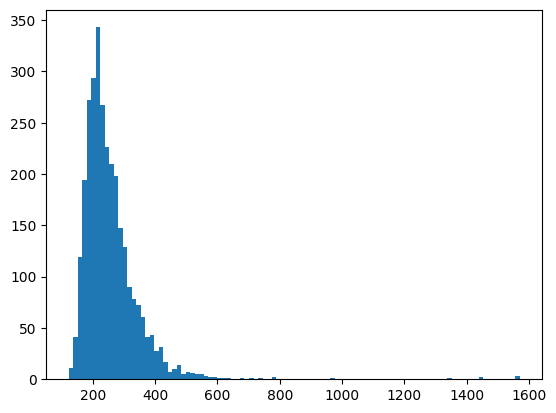

255.42265285666556


In [9]:
import numpy as np
from transformers import AutoTokenizer, AutoModel
bert_tokenizer = AutoTokenizer.from_pretrained("AshtonIsNotHere/GatorTron-OG")
bert_model = AutoModel.from_pretrained("bert-base-uncased")
token_list = []
for file_path in all_edf_paths:
    report = _read_physician_report(file_path)
    token_list.append(bert_tokenizer.tokenize(report))

print(token_list[0])
#draw a histogram of the number of tokens in each string
import matplotlib.pyplot as plt
plt.hist([len(x) for x in token_list], bins=100)
plt.show()
print(np.mean([len(x) for x in token_list]))

